**About Dataset**

**Context**

Satellite imagery provides unique insights into various markets, including agriculture, defense and intelligence, energy, and finance. New commercial imagery providers, such as Planet, are using constellations of small satellites to capture images of the entire Earth every day.
This flood of new imagery is outgrowing the ability for organizations to manually look at each image that gets captured, and there is a need for machine learning and computer vision algorithms to help automate the analysis process.
The aim of this dataset is to help address the difficult task of detecting the location of airplanes in satellite images. Automating this process can be applied to many issues including monitoring airports for activity and traffic patterns, and defense intelligence.

**Content**

The dataset consists of images extracted from Planet satellite imagery collected over multiple airports in California. It includes 32,000 20x20 RGB images labeled with either a "plane" or "no-plane" classification. Images were derived from PlanetScope full-frame visual scene products, which are orthorectified to a 3-meter pixel size.

Provided is a zipped directory planesnet.zip that contains the entire dataset as .png images. Each individual image filename follows a specific format: {label} _ {scene id} _ {longitude} _ {latitude}.png

**label:** Valued 1 or 0, representing the "plane" class and "no-plane" class, respectively.

**scene id:** The unique identifier of the PlanetScope visual scene the image was extracted from. The scene id can be used with the Planet API to discover and download the entire scene.

**longitude_latitude:** The longitude and latitude coordinates of the image center point, with values separated by a single underscore.

The dataset is also distributed as a JSON formatted text file planesnet.json. The loaded object contains data, label, scene_ids, and location lists.

The pixel value data for each 20x20 RGB image is stored as a list of 1200 integers within the data list. The first 400 entries contain the red channel values, the next 400 the green, and the final 400 the blue. The image is stored in row-major order so that the first 20 entries of the array are the red channel values of the first row of the image.

The list values at index i in labels, scene_ids, and locations each correspond to the i-th image in the data list.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import json

'''dataset = open('/kaggle/input/planesnet/planesnet.json')
data = json.load(dataset)
dataset.close()'''


path = '/kaggle/input/planesnet/planesnet/planesnet/'

In [2]:
#creating function to create array of images and labels 

from PIL import Image
from tqdm import tqdm
from glob import glob

def create_data(path_name):
    images = [np.zeros([20,20,3])]
    labels = [0]
    for img in tqdm(os.listdir(path_name)):
        if(img[0]=='1'):
            labels.append(1)
        else:
            labels.append(0)
        image = Image.open(os.path.join(path_name,img))
        image = np.array(image)
        images.append(image)
        
    return np.array(images),np.array(labels)
images, labels = create_data(path)

100%|██████████| 32000/32000 [04:50<00:00, 110.05it/s]


In [3]:
print(images[0].shape)
print(labels[50:60])

(20, 20, 3)
[1 0 1 0 1 1 0 0 1 1]


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.25, random_state = 42)

In [5]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(24000, 20, 20, 3)
(8001, 20, 20, 3)
(24000,)
(8001,)


In [6]:
#RESHAPING AND NORMALIZATION
X_train = X_train.astype('float32')
X_train = X_train.reshape(X_train.shape[0],20,20,3)
X_train = X_train / 255.

X_test = X_test.astype('float32')
X_test = X_test.reshape(X_test.shape[0], 20,20,3)
X_test = X_test / 255.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, Dropout, Dense, Flatten, BatchNormalization, MaxPooling2D

# model architecture building
model_1 = Sequential()

model_1.add(BatchNormalization(input_shape = (20, 20, 3)))

model_1.add(Convolution2D(filters = 32, kernel_size = 3, activation ='relu', input_shape = (20, 20, 3))) 
model_1.add(MaxPooling2D(pool_size = 2))


model_1.add(Convolution2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model_1.add(MaxPooling2D(pool_size = 2))

model_1.add(Flatten()) 

# fully connected layer
model_1.add(Dense(units = 64,activation = 'relu'))

# Classification layer
model_1.add(Dense(units = 1, activation = 'sigmoid')) 

In [8]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.0001)
model_1.compile(optimizer=opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 20, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 18, 18, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [9]:
model = model_1.fit(X_train, y_train, epochs = 30, batch_size = 32, validation_data = (X_test, y_test),verbose=1)


Epoch 1/30
750/750 [==============================] - 9s 12ms/step - loss: 0.2880 - accuracy: 0.8832 - val_loss: 0.1963 - val_accuracy: 0.9275
Epoch 2/30
750/750 [==============================] - 10s 13ms/step - loss: 0.1668 - accuracy: 0.9378 - val_loss: 0.1357 - val_accuracy: 0.9514
Epoch 3/30
750/750 [==============================] - 9s 11ms/step - loss: 0.1268 - accuracy: 0.9541 - val_loss: 0.1117 - val_accuracy: 0.9583
Epoch 4/30
750/750 [==============================] - 9s 11ms/step - loss: 0.1057 - accuracy: 0.9620 - val_loss: 0.1051 - val_accuracy: 0.9601
Epoch 5/30
750/750 [==============================] - 8s 11ms/step - loss: 0.0942 - accuracy: 0.9653 - val_loss: 0.0862 - val_accuracy: 0.9690
Epoch 6/30
750/750 [==============================] - 10s 13ms/step - loss: 0.0866 - accuracy: 0.9680 - val_loss: 0.0812 - val_accuracy: 0.9714
Epoch 7/30
750/750 [==============================] - 8s 11ms/step - loss: 0.0801 - accuracy: 0.9704 - val_loss: 0.0751 - val_accuracy: 0.97

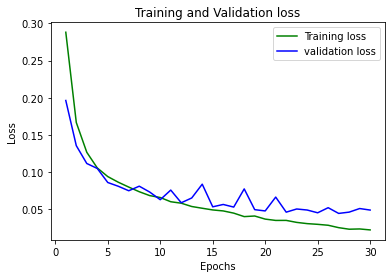

In [10]:
EPOCH=30
loss_train = model.history['loss']
loss_val = model.history['val_loss']
epochs = range(1,EPOCH+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

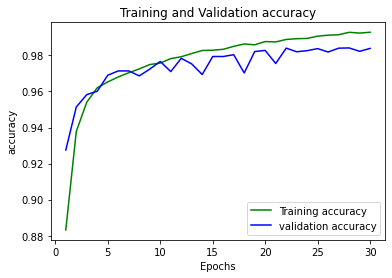

In [11]:
EPOCH=30
Acc_train = model.history['accuracy']
Acc_val = model.history['val_accuracy']
epochs = range(1,EPOCH+1)
plt.plot(epochs, Acc_train, 'g', label='Training accuracy')
plt.plot(epochs, Acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()